In [96]:
import scanpy as sc
import torch
import argparse
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.model import Discriminator
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from torch import optim
from torch import nn
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
import yaml
import pandas as pd

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/classifier_training/")
# from train_classifier import Classifier

Performance before correction

UNCORRECTED

In [82]:
class Classifier(LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X, labels = batch["X"], batch["mol_one_hot"].argmax(1)
        outputs = self.model(X, None)
        loss = self.criterion(outputs, labels)
        return loss

    def val_step(self, batch, batch_idx):
        X, labels = batch["X"], batch["mol_one_hot"].argmax(1)
        outputs = self.model(X, None)
        print(X.device)
        loss = self.criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).sum().item() / len(labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.val_step(batch, batch_idx)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss = self.val_step(batch, batch_idx)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [83]:
ckpt_uncorrected= "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/pert_classifier_results/rxrx1/best_model_old.ckpt"
args_path_uncorrected = "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/classifier_training/compound_classifier_rxrx1_normal.yaml"

In [84]:
args_uncorrected = yaml.safe_load(args_path_uncorrected)
with open(args_path_uncorrected, 'r') as file_uncorrected:
        args_uncorrected = yaml.safe_load(file_uncorrected)
    
args_uncorrected = OmegaConf.create(args_uncorrected)
dataloader_uncorrected = CellDataLoader(args_uncorrected)

classifier_net_uncorrected = Discriminator(img_size=96,
                                num_domains=dataloader_uncorrected.n_mol, 
                                max_conv_dim=512, 
                                in_channels=args_uncorrected.n_channels, 
                                dim_in=64,
                                multi_task=False)

# Set up the checkpoint callback
dest_path_uncorrected = Path(args_uncorrected.dest_path)
checkpoint_callback_uncorrected = ModelCheckpoint(
    dirpath=ckpt_uncorrected,
    filename='best_model',
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)

classifier_uncorrected = Classifier(classifier_net_uncorrected, learning_rate=0.0001)
classifier_uncorrected.load_state_dict(torch.load(ckpt_uncorrected)["state_dict"])

# Set up the trainer with the checkpoint callback
trainer_uncorrected= Trainer(
    max_epochs=50,
    callbacks=[checkpoint_callback_uncorrected],
)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /home/icb/alessandro.palma/miniconda3/envs/IMPA_t ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [85]:
trainer_uncorrected.test(classifier_uncorrected, dataloader_uncorrected.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


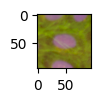

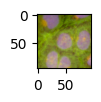

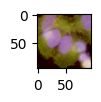

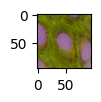

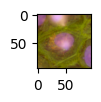

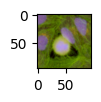

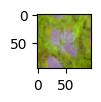

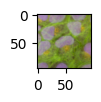

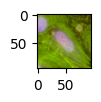

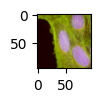

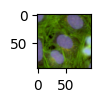

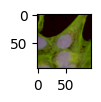

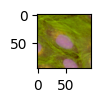

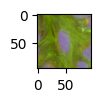

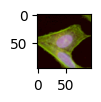

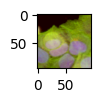

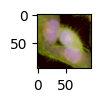

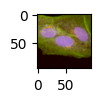

KeyboardInterrupt: 

In [87]:
for b in dataloader_uncorrected.val_dataloader():
    X = b["X"]
    plt.figure(figsize=(0.7,0.7))
    plt.imshow((X[0].permute(1,2,0).numpy()[:,:,[5,2,0]]+1)/2 )
    plt.show()

In [91]:
X.dtype

torch.float32

CORRECTED

In [70]:
ckpt_corrected= "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/pert_classifier_results/rxrx1_transported/best_model.ckpt"
args_path_corrected = "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/classifier_training/compound_classifier_rxrx1_transported.yaml"

In [71]:
args_corrected = yaml.safe_load(args_path_corrected)
with open(args_path_corrected, 'r') as file_corrected:
        args_corrected = yaml.safe_load(file_corrected)
    
args_corrected = OmegaConf.create(args_corrected)
dataloader_corrected = CellDataLoader(args_corrected)

classifier_net_corrected = Discriminator(img_size=96,
                                num_domains=dataloader_corrected.n_mol, 
                                max_conv_dim=512, 
                                in_channels=args_corrected.n_channels, 
                                dim_in=64,
                                multi_task=False)

# Set up the checkpoint callback
dest_path_corrected = Path(args_corrected.dest_path)
checkpoint_callback_corrected = ModelCheckpoint(
    dirpath=ckpt_corrected,
    filename='best_model',
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)

classifier_corrected = Classifier(classifier_net_corrected, learning_rate=0.0001)
classifier_corrected.load_state_dict(torch.load(ckpt_corrected)["state_dict"])

# Set up the trainer with the checkpoint callback
trainer_corrected= Trainer(
    max_epochs=50,
    callbacks=[checkpoint_callback_corrected],
)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /home/icb/alessandro.palma/miniconda3/envs/IMPA_t ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
trainer_corrected.test(classifier_corrected, dataloader_corrected.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

tensor([ 281,  621,   29,  204,   86,  344,   12, 1025,  285, 1039,  639,  355,
         966,  319,  996,  989,  745,  564,  480,   81,  462, 1054,  149,  813,
         318,  149,  260,  388,  585, 1037,  301,   36,   96,  468,  839,  221,
        1066,  571,  110,  649,  974,  135,  316,  709,  996,  662,  316,  169,
         480,  325,   53,  160,  767,  995,  940,  132,  266,  197,  266,  480,
         810,  297,  349,  319], device='cuda:0')
tensor([1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025,  989,  989,
         989,  989,  989,  989,  989,  989,  989,  989,  149,  149,  149,  149,
         149,  149,  149,  149,  149,  149,  624,  624,  624,  624,  624,  624,
         624,  624,  624,  624,  325,  325,  325,  325,  325,  325,  325,  325,
         325,  325,  160,  160,  160,  160,  160,  160,  160,  160,  160,  160,
         349,  349,  349,  349], device='cuda:0')
tensor([ 529,  930,  674,  521, 1050,  219,  760,  360,  925,  698,  272,  843,
         775,  286, 

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [36]:
classifier_net_corrected

Discriminator(
  (conv): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResBlk(
      (actv): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1x1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResBlk(
      (actv): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1x1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlk(
      (actv): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1x1): Conv2d(256, 512, kern

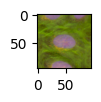

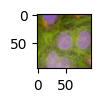

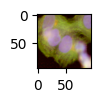

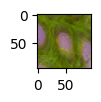

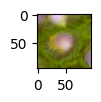

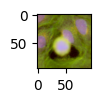

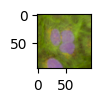

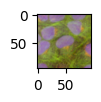

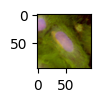

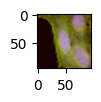

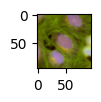

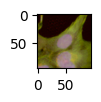

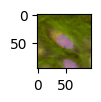

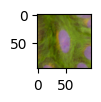

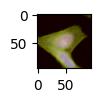

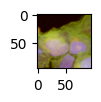

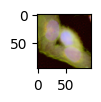

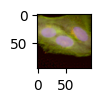

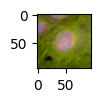

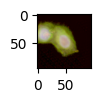

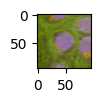

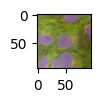

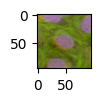

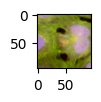

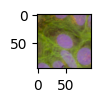

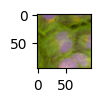

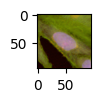

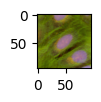

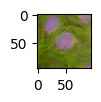

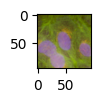

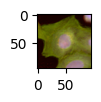

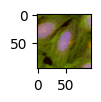

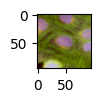

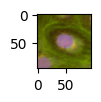

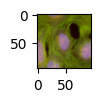

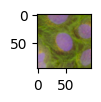

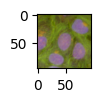

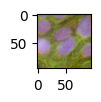

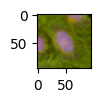

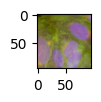

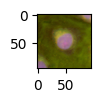

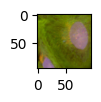

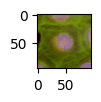

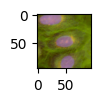

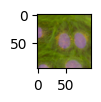

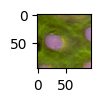

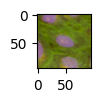

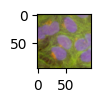

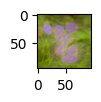

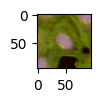

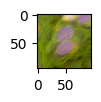

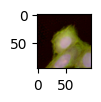

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


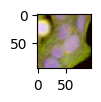

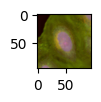

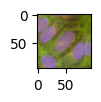

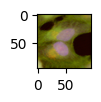

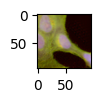

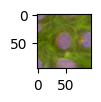

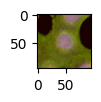

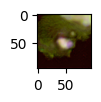

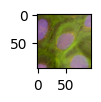

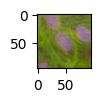

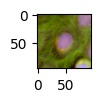

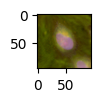

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


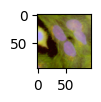

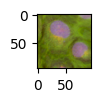

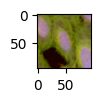

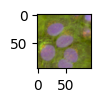

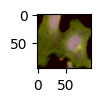

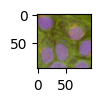

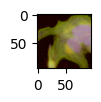

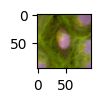

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


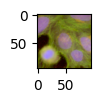

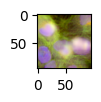

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


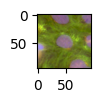

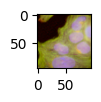

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


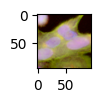

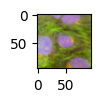

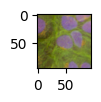

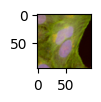

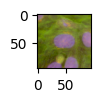

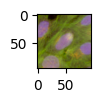

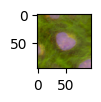

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


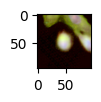

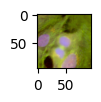

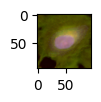

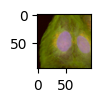

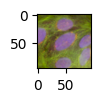

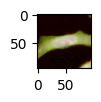

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


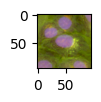

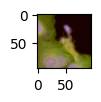

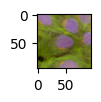

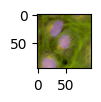

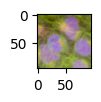

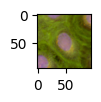

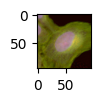

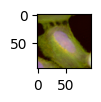

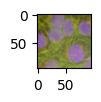

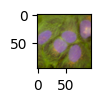

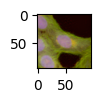

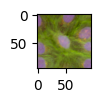

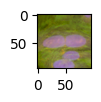

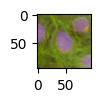

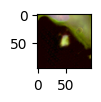

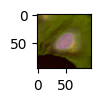

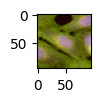

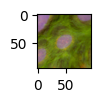

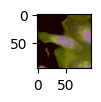

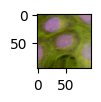

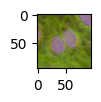

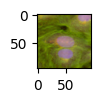

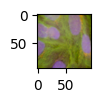

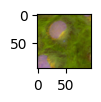

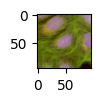

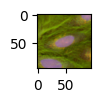

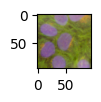

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


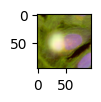

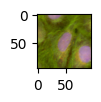

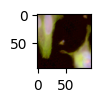

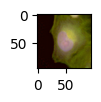

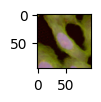

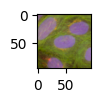

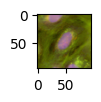

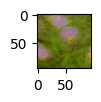

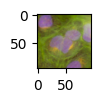

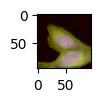

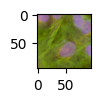

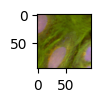

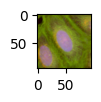

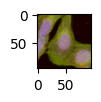

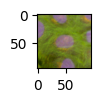

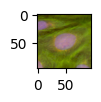

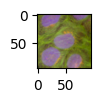

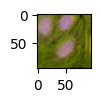

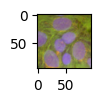

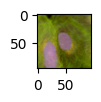

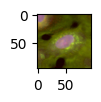

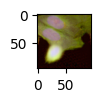

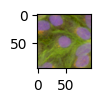

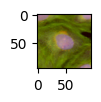

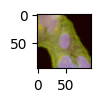

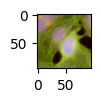

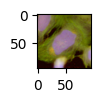

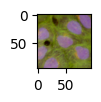

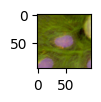

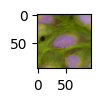

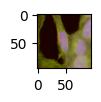

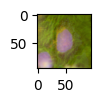

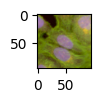

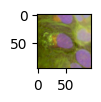

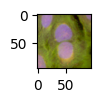

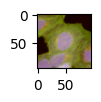

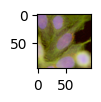

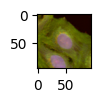

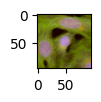

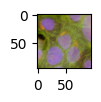

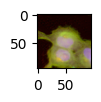

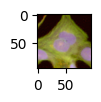

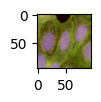

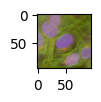

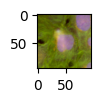

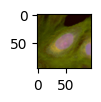

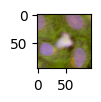

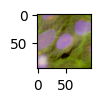

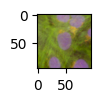

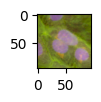

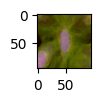

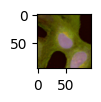

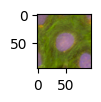

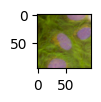

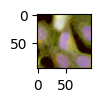

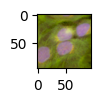

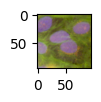

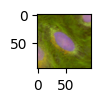

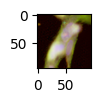

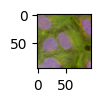

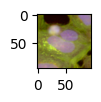

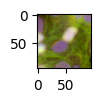

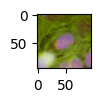

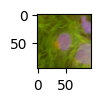

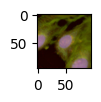

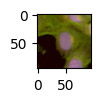

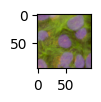

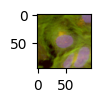

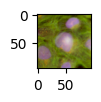

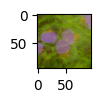

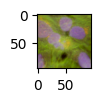

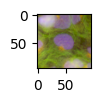

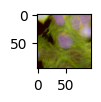

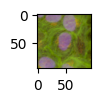

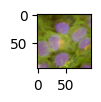

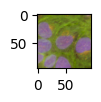

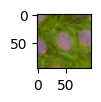

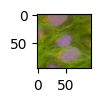

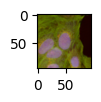

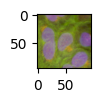

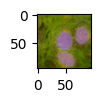

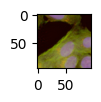

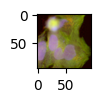

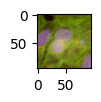

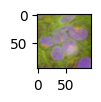

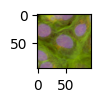

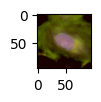

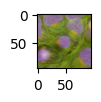

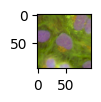

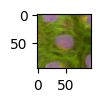

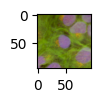

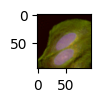

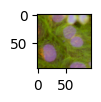

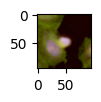

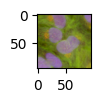

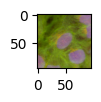

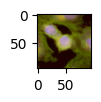

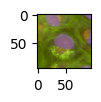

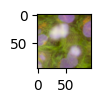

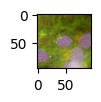

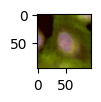

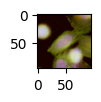

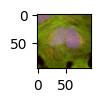

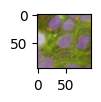

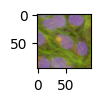

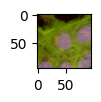

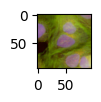

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


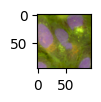

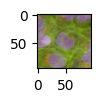

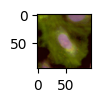

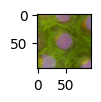

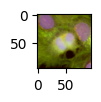

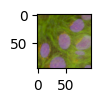

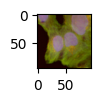

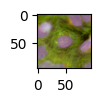

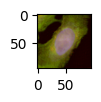

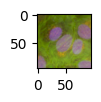

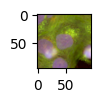

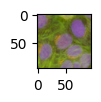

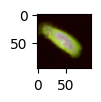

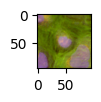

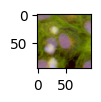

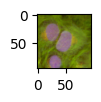

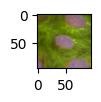

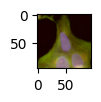

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


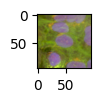

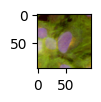

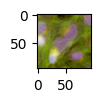

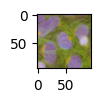

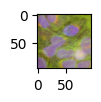

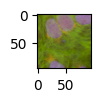

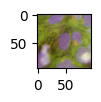

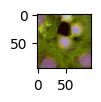

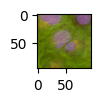

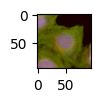

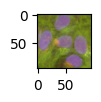

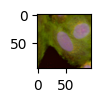

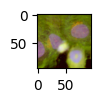

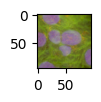

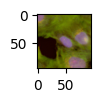

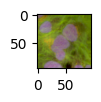

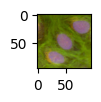

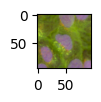

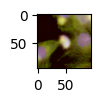

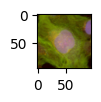

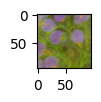

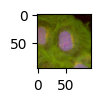

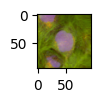

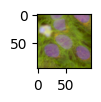

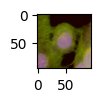

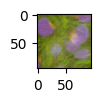

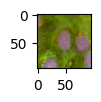

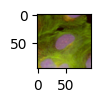

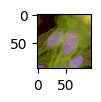

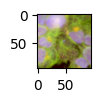

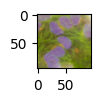

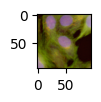

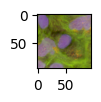

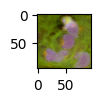

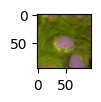

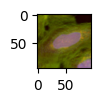

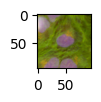

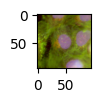

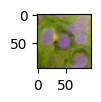

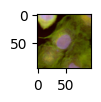

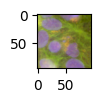

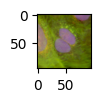

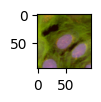

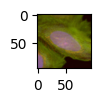

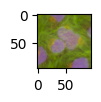

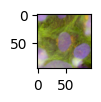

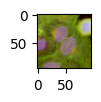

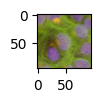

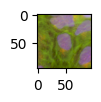

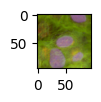

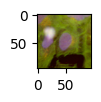

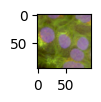

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


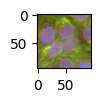

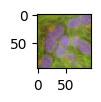

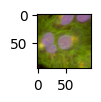

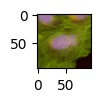

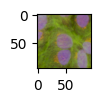

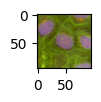

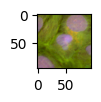

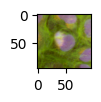

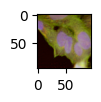

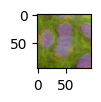

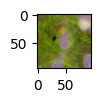

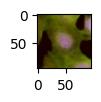

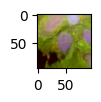

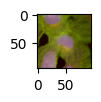

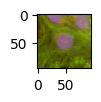

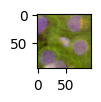

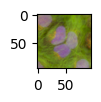

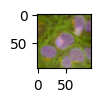

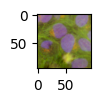

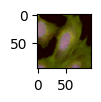

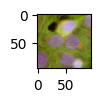

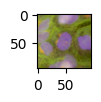

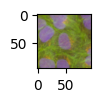

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


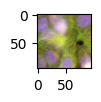

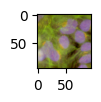

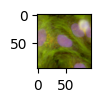

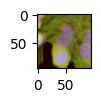

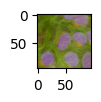

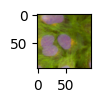

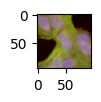

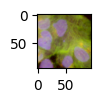

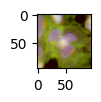

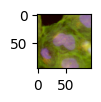

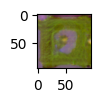

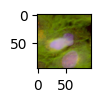

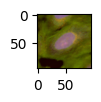

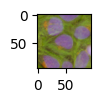

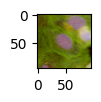

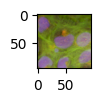

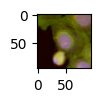

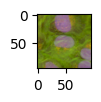

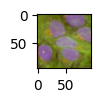

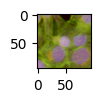

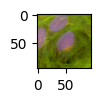

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


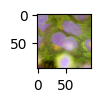

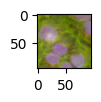

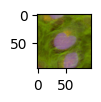

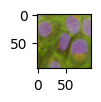

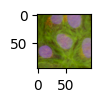

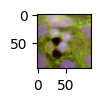

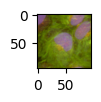

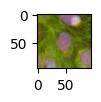

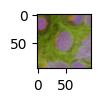

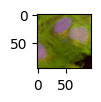

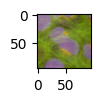

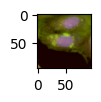

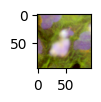

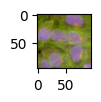

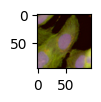

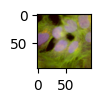

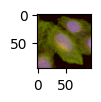

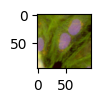

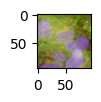

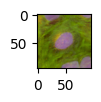

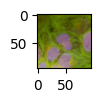

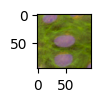

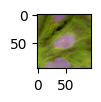

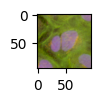

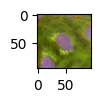

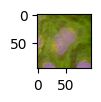

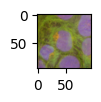

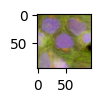

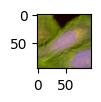

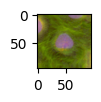

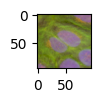

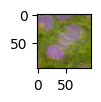

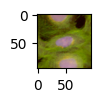

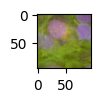

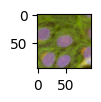

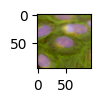

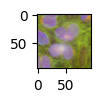

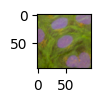

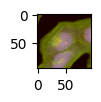

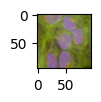

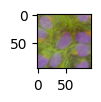

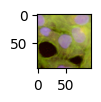

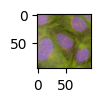

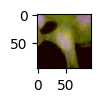

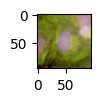

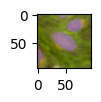

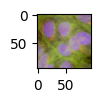

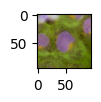

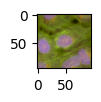

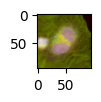

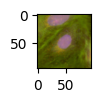

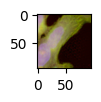

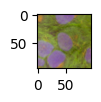

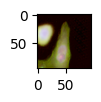

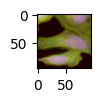

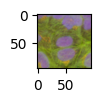

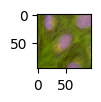

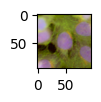

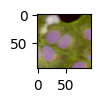

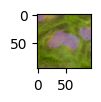

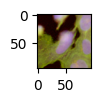

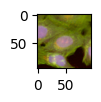

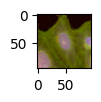

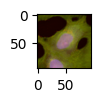

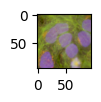

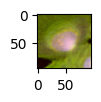

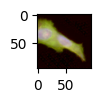

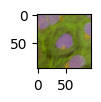

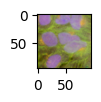

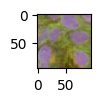

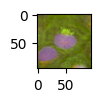

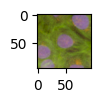

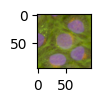

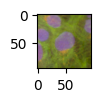

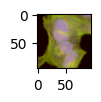

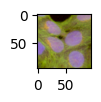

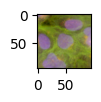

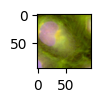

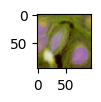

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


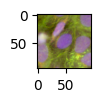

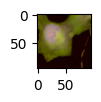

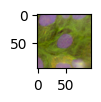

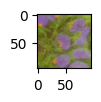

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


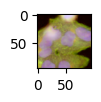

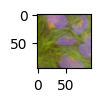

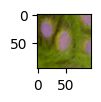

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


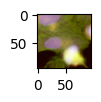

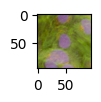

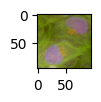

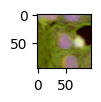

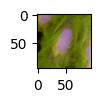

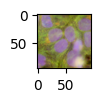

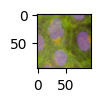

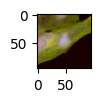

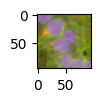

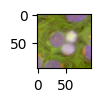

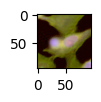

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


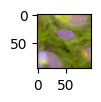

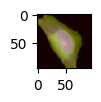

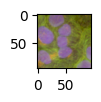

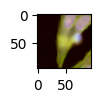

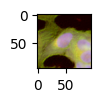

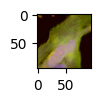

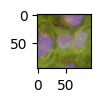

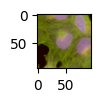

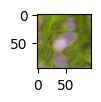

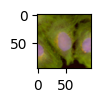

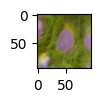

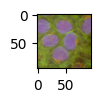

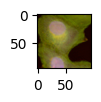

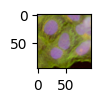

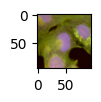

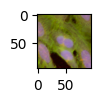

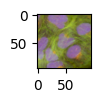

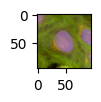

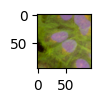

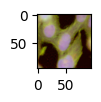

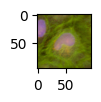

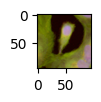

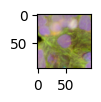

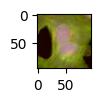

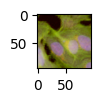

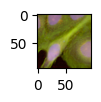

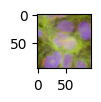

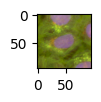

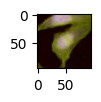

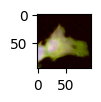

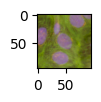

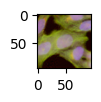

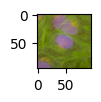

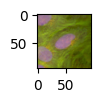

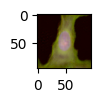

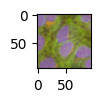

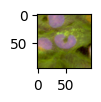

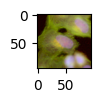

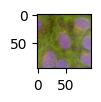

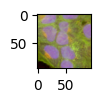

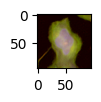

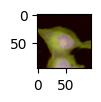

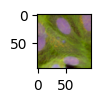

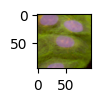

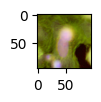

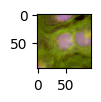

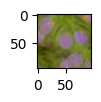

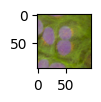

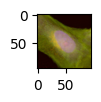

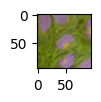

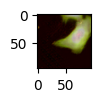

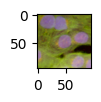

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


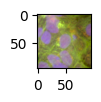

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


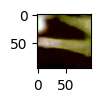

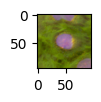

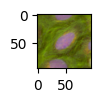

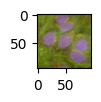

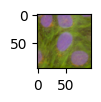

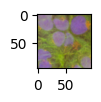

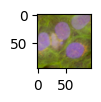

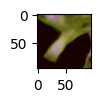

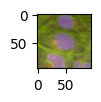

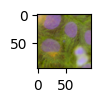

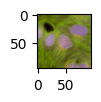

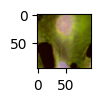

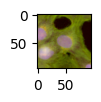

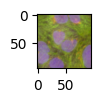

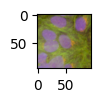

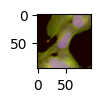

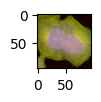

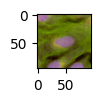

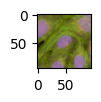

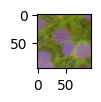

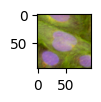

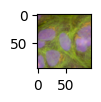

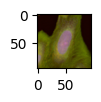

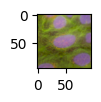

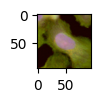

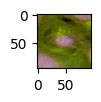

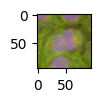

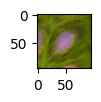

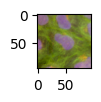

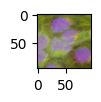

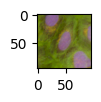

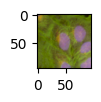

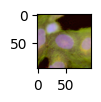

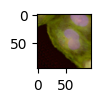

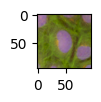

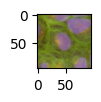

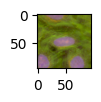

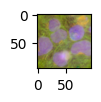

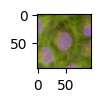

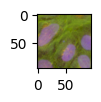

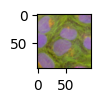

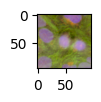

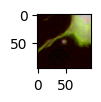

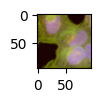

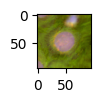

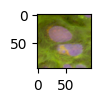

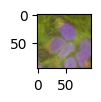

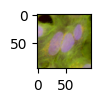

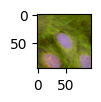

In [98]:
for b in dataloader_corrected.val_dataloader():
    X = b["X"]
    plt.figure(figsize=(0.7,0.7))
    plt.imshow((X[0].permute(1,2,0).numpy()[:,:,[5,2,0]]+1)/2 )
    plt.show()